# Background

can we develop a multi-template hybrid model that can be trained on LHS data from one
template and then used to predict the response of another template?

we may want to use minimal data from the second template to fine-tune the model, but
the goal is to have a model that can generalize across different templates.

we can start with the eGFP kinetic model and then identify multi-template structure
that can be used to train the machine learning model.


In [1]:
import r3.adapters as adapters
import r3.schema as schema
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    Matern,
    RBF,
    WhiteKernel,
    ConstantKernel as C,
)
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import plotly.graph_objects as go
from r3.models.machine_learning.pls import calculate_vip
import shap
import xgboost

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]
experimental_conditions, response = adapters.DataPipelineAdapter(
    "egfp_lhs", verbose=False
).get(X_columns=X_columns, y_columns=y_columns)

# Remove sample 11
experimental_conditions = experimental_conditions.drop(index=[11])
response = response.drop(index=[11])

experimental_data = experimental_conditions
experimental_data[y_columns[0]] = response[y_columns[0]]
experimental_data

,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min],RNA [g/L]
0,0.052,342,27,0.079,126.0,5.625938
1,0.012,210,29,0.088,114.0,2.049225
2,0.020,135,21,0.050,240.0,2.395913
3,0.040,378,97,0.045,42.0,9.591750
4,0.020,246,83,0.070,192.0,5.397412
5,0.048,213,98,0.067,18.0,5.246775
6,0.040,195,24,0.041,54.0,3.955950
7,0.056,271,94,0.007,108.0,0.083775
8,0.016,186,53,0.062,54.0,3.621188
9,0.052,288,66,0.010,138.0,0.140887


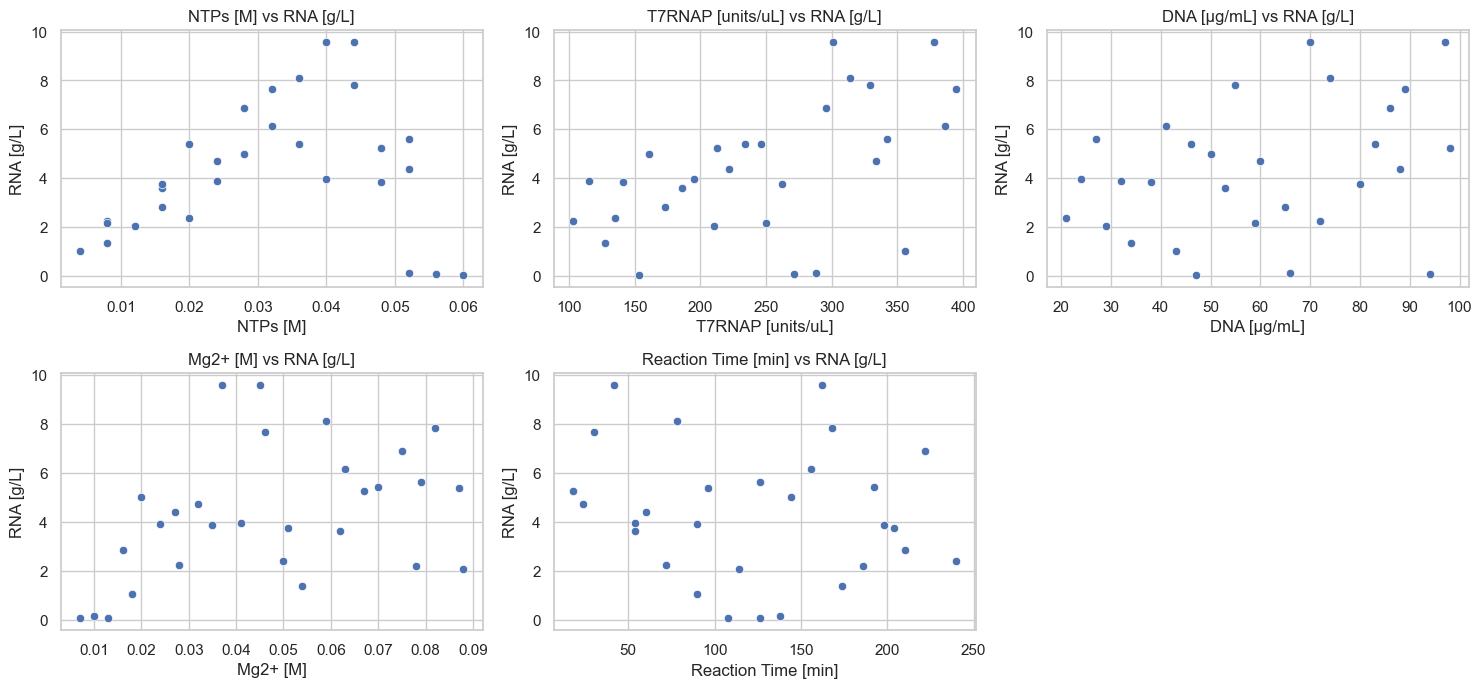

In [2]:
# plot the experimental conditions against the response in a grid
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=experimental_data, x=col, y=y_columns[0])
    plt.title(f"{col} vs {y_columns[0]}")
    plt.xlabel(col)
    plt.ylabel(y_columns[0])
plt.tight_layout()

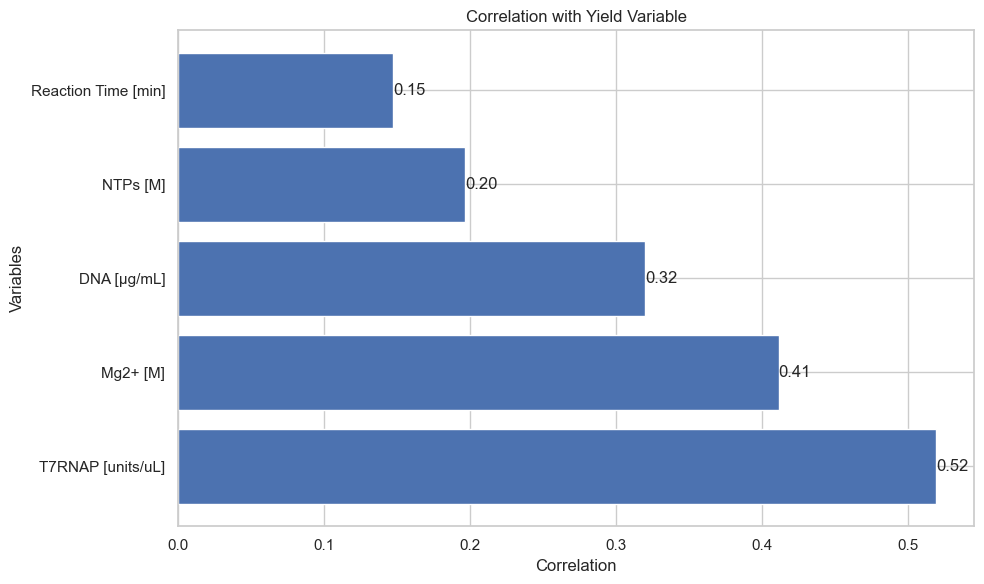

In [3]:
# Calculate the correlation coefficients with the yield variable
corr_matrix = experimental_data.corr()
correlations = corr_matrix[y_columns[0]].drop(y_columns[0])

# Sort the correlations in descending order
correlations = correlations.abs().sort_values(ascending=False)

# Create a horizontal bar chart of the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values)
plt.xlabel("Correlation")
plt.ylabel("Variables")
plt.title("Correlation with Yield Variable")
plt.tight_layout()
# add correlation values to the bars
for index, value in enumerate(correlations):
    plt.text(value, index, f"{value:.2f}", va="center")

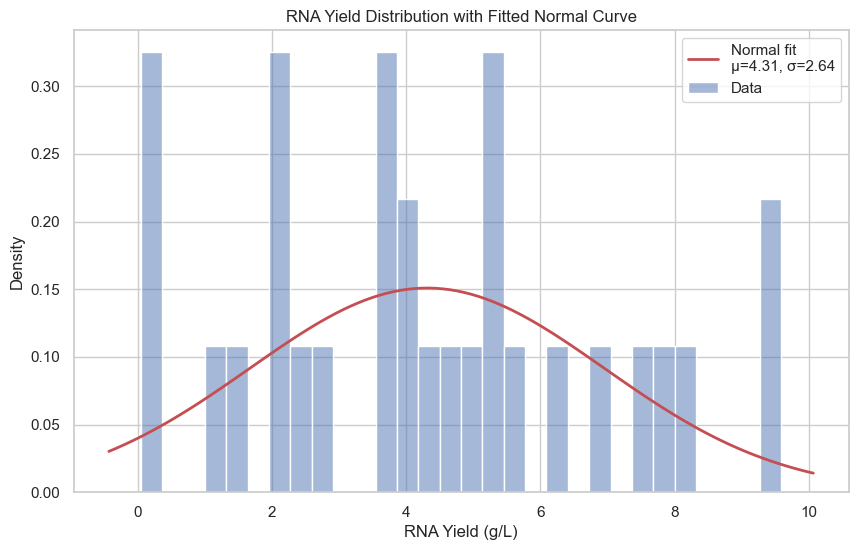

In [4]:
# Fit a normal distribution
mu, std = stats.norm.fit(response.values)

# Plot histogram and fitted PDF
plt.figure(figsize=(10, 6))
sns.histplot(
    response.values, bins=30, kde=False, stat="density", color="skyblue", label="Data"
)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("RNA Yield Distribution with Fitted Normal Curve")
plt.xlabel("RNA Yield (g/L)")
plt.ylabel("Density")
plt.legend()
plt.show()

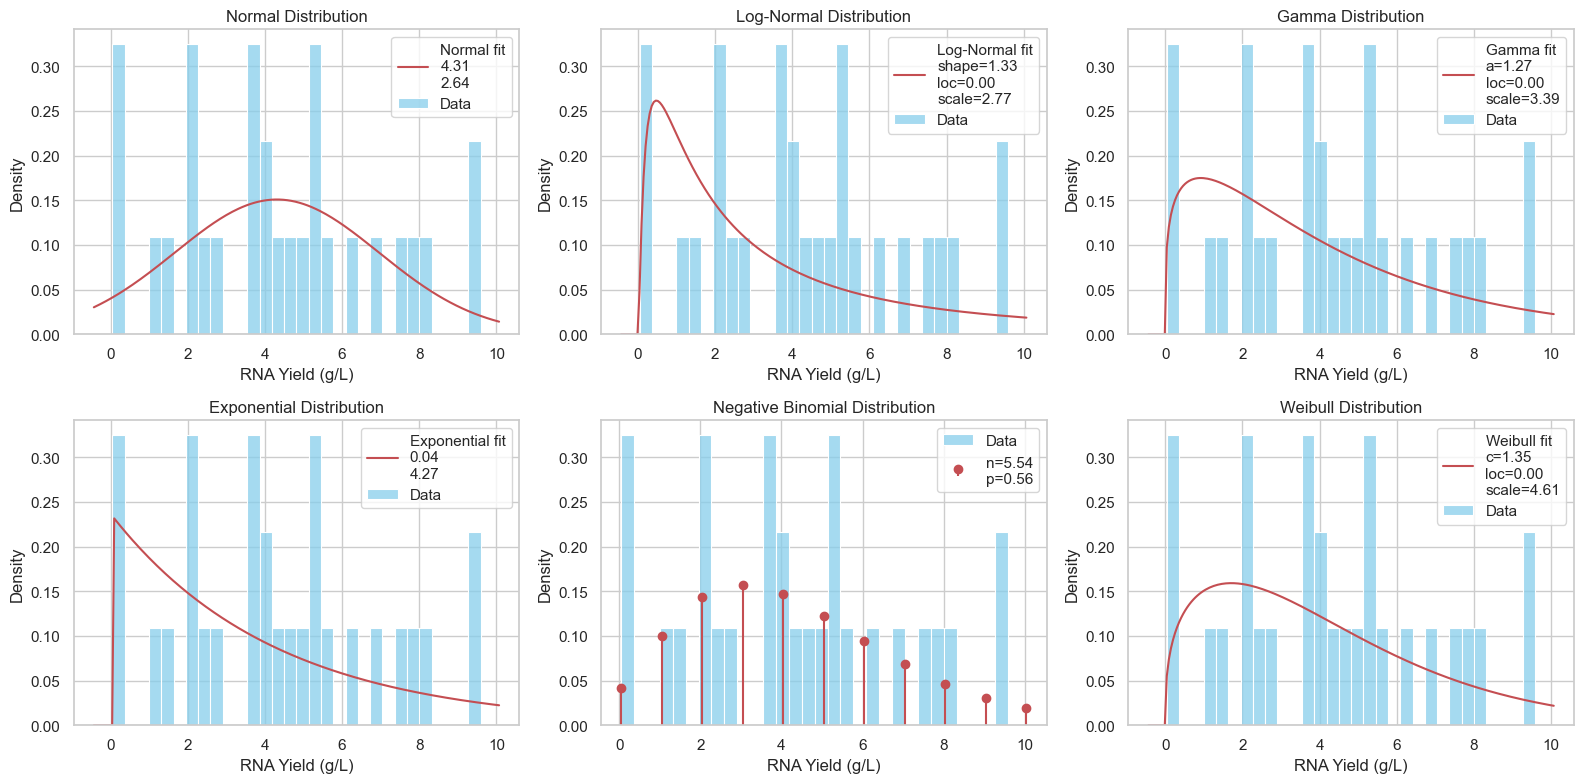

Normality Tests:
Shapiro-Wilk: W=0.967, p=0.492
Anderson-Darling: statistic=0.225, critical_values=[0.52  0.592 0.71  0.828 0.985]

Goodness-of-fit (Kolmogorov-Smirnov) for each distribution:
Normal: KS statistic=0.076, p=0.992
Log-Normal: KS statistic=0.238, p=0.0632
Gamma: KS statistic=0.087, p=0.967
Exponential: KS statistic=0.223, p=0.0958
Negative Binomial: KS statistic=0.244, p=0.053
Weibull: KS statistic=0.169, p=0.343


In [5]:
rna_yield = response[y_columns[0]].dropna().values

# List of distributions to fit (Beta removed)
distributions = {
    "Normal": stats.norm,
    "Log-Normal": stats.lognorm,
    "Gamma": stats.gamma,
    "Exponential": stats.expon,
    "Negative Binomial": stats.nbinom,
    "Weibull": stats.weibull_min,
}

plt.figure(figsize=(16, 8))
for i, (name, dist) in enumerate(distributions.items(), 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        rna_yield, bins=30, kde=False, stat="density", color="skyblue", label="Data"
    )
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    if name == "Log-Normal":
        shape, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, shape, loc, scale)
        label = f"shape={shape:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Gamma":
        a, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, a, loc, scale)
        label = f"a={a:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Negative Binomial":
        data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
        data_nb = data_nb[data_nb >= 0]
        mean_nb = np.mean(data_nb)
        var_nb = np.var(data_nb)
        if var_nb > mean_nb:
            p = mean_nb / var_nb
            n = mean_nb * p / (1 - p)
            x_nb = np.arange(data_nb.min(), data_nb.max() + 1)
            pmf = stats.nbinom.pmf(x_nb, n, p)
            plt.stem(
                x_nb + rna_yield.min(),
                pmf,
                linefmt="r-",
                markerfmt="ro",
                basefmt=" ",
                label=f"n={n:.2f}\np={p:.2f}",
            )
            label = f"n={n:.2f}\np={p:.2f}"
        else:
            label = "var <= mean, NB not valid"
        pdf = None
    elif name == "Weibull":
        c, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, c, loc, scale)
        label = f"c={c:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    else:
        params = dist.fit(rna_yield)
        pdf = dist.pdf(x, *params)
        label = "\n".join([f"{p:.2f}" for p in params])
    if name != "Negative Binomial":
        plt.plot(x, pdf, "r", label=f"{name} fit\n{label}")
    plt.title(f"{name} Distribution")
    plt.xlabel("RNA Yield (g/L)")
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()

# Statistical tests
print("Normality Tests:")
shapiro_stat, shapiro_p = stats.shapiro(rna_yield)
print(f"Shapiro-Wilk: W={shapiro_stat:.3f}, p={shapiro_p:.3g}")
ad_result = stats.anderson(rna_yield, dist="norm")
print(
    f"Anderson-Darling: statistic={ad_result.statistic:.3f}, critical_values={ad_result.critical_values}"
)

print("\nGoodness-of-fit (Kolmogorov-Smirnov) for each distribution:")
for name, dist in distributions.items():
    try:
        if name == "Log-Normal":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "lognorm", args=params)
        elif name == "Negative Binomial":
            data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
            data_nb = data_nb[data_nb >= 0]
            mean_nb = np.mean(data_nb)
            var_nb = np.var(data_nb)
            if var_nb > mean_nb:
                p = mean_nb / var_nb
                n = mean_nb * p / (1 - p)
                d_stat, p_val = stats.kstest(data_nb, "nbinom", args=(n, p, 0))
                print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
            else:
                print(f"{name}: KS test not valid (var <= mean)")
            continue
        elif name == "Weibull":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "weibull_min", args=params)
        elif name == "Normal":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "norm", args=params)
        elif name == "Exponential":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "expon", args=params)
        else:
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, name.lower(), args=params)
        print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
    except Exception as e:
        print(f"{name}: KS test not available ({e})")

**Statistical significance** in this context means the test **rejects the null
hypothesis** (i.e., the data does **not** follow the distribution) if the p-value is
**less than 0.05**.

- **Shapiro-Wilk (Normality):** p = 0.215 (> 0.05) → **Do not reject normality**
- **Anderson-Darling (Normality):** statistic = 0.338 < 0.521 (critical value for
  15%) → **Do not reject normality**

**KS Goodness-of-fit (all p > 0.05):**

- Normal: p = 0.861
- Log-Normal: p = 0.0692
- Gamma: p = 0.869
- Exponential: p = 0.125
- Negative Binomial: p = 0.0826
- Weibull: p = 0.404

**Conclusion:**  
**None** of the distributions are statistically rejected (all p > 0.05).  
**Normal and Gamma** have the highest p-values, suggesting they fit your data best.  
You can say your data is statistically consistent with all these distributions.


## Exploratory Data Analysis

Can we find statistically significant features that can explain the variance in the
data to identify statistically significant features.


In [6]:
X_train, y_train = experimental_conditions[X_columns], response[y_columns[0]]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

df = pd.DataFrame(X_train_scaled, columns=X_columns)
df[y_columns[0]] = y_train_scaled
df

,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min],RNA [g/L]
0,1.284188,1.125822,-1.390633,1.306528,0.042298,0.497254
1,-1.182133,-0.412239,-1.304645,1.674386,-0.146418,-0.855248
2,-0.688869,-1.286137,-1.648596,0.121210,1.835100,-0.724151
3,0.544292,1.545293,1.618945,-0.083156,-1.278713,1.996892
4,-0.688869,0.007232,1.017030,0.938671,1.080236,0.410840
5,1.037556,-0.377283,1.661939,0.816052,-1.656145,0.353877
6,0.544292,-0.587018,-1.519615,-0.246648,-1.089997,-0.134237
7,1.530820,0.298532,1.489964,-1.636332,-0.240776,-1.598466
8,-0.935501,-0.691886,-0.272789,0.611686,-1.089997,-0.260824
9,1.284188,0.496615,0.286132,-1.513712,0.231014,-1.576870


## Preliminary Model Screening

Gaussian Process Regression (GPR) are commonly used for LHS data modelling. XGboost
on the other hand is considered the state of the art model that can handle non-linear
relationships in tabular data.


In [7]:
xgboost_model = xgboost.XGBRegressor(
    n_estimators=10,
    max_depth=3,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
)
xgboost_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
y_pred_scaled = xgboost_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
print("Predictions on train set:\n", predictions)
print("Actual values on train set:\n", y_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions))
print("Root Mean squared error on train set:", rmse)
print(
    "R-squared score on train set:",
    xgboost_model.score(X_train_scaled, y_train_scaled),
)

Predictions on train set:
 [5.239374  3.0774088 4.1505346 6.724728  4.2478614 4.3626356 4.265309
 2.0287578 3.8547292 2.0287578 6.724728  3.0774088 4.3626356 6.724728
 6.268686  3.1747353 4.265309  4.3626356 2.9314988 4.521127  5.2992945
 3.6341946 6.6206765 4.265309  6.3727374 3.0774088 4.1505346 3.9520557
 2.0287578]
Actual values on train set:
 0     5.625938
1     2.049225
2     2.395913
3     9.591750
4     5.397412
5     5.246775
6     3.955950
7     0.083775
8     3.621188
9     0.140887
10    8.094150
12    2.244300
13    4.400000
14    9.586425
15    6.872400
16    2.174100
17    4.996537
18    5.389950
19    1.033837
20    4.722000
21    6.145050
22    2.844787
23    7.647375
24    3.860000
25    7.811662
26    1.374637
27    3.911025
28    3.756638
29    0.043612
Name: RNA [g/L], dtype: float64
Root Mean squared error on train set: 1.3264685715887634
R-squared score on train set: 0.7484049247872482


Using the same Gaussian Process Kernel in (SS. Rosa et al., 2022).


Root Mean squared error on training set: 0.1738714305968435
R-squared score on training: 0.995677204893416


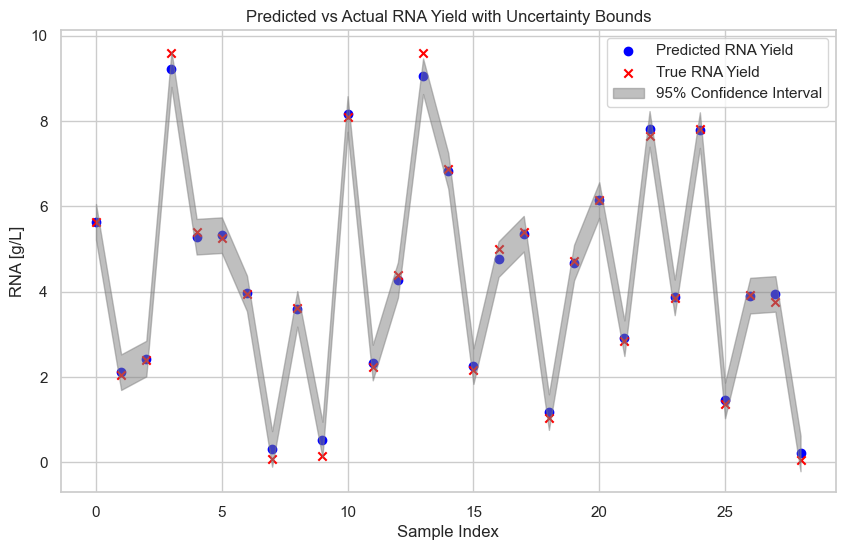

In [8]:
matern_gp_model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=100,
    random_state=42,
)
matern_gp_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
pre_scaled_pred = matern_gp_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(pre_scaled_pred.reshape(-1, 1)).flatten()
print(
    "Root Mean squared error on training set:",
    np.sqrt(mean_squared_error(y_train, predictions)),
)
print(
    "R-squared score on training:",
    matern_gp_model.score(X_train_scaled, y_train_scaled),
)

x_axis = np.arange(len(X_train))
plt.figure(figsize=(10, 6))
plt.scatter(
    x_axis,
    predictions,
    label="Predicted RNA Yield",
    color="blue",
    marker="o",
)
plt.scatter(x_axis, y_train, label="True RNA Yield", color="red", marker="x")
plt.fill_between(
    x_axis,
    predictions - 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    predictions + 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Predicted vs Actual RNA Yield with Uncertainty Bounds")
plt.legend()

Trying with an RBF Kernel which provides the best trade-off between flexibility and
smoothness. It is a good choice for many regression tasks, especially when the data
is not too noisy.


Root Mean squared error on training set: 0.4391570215210468
R-squared score on training: 0.9724229467274552


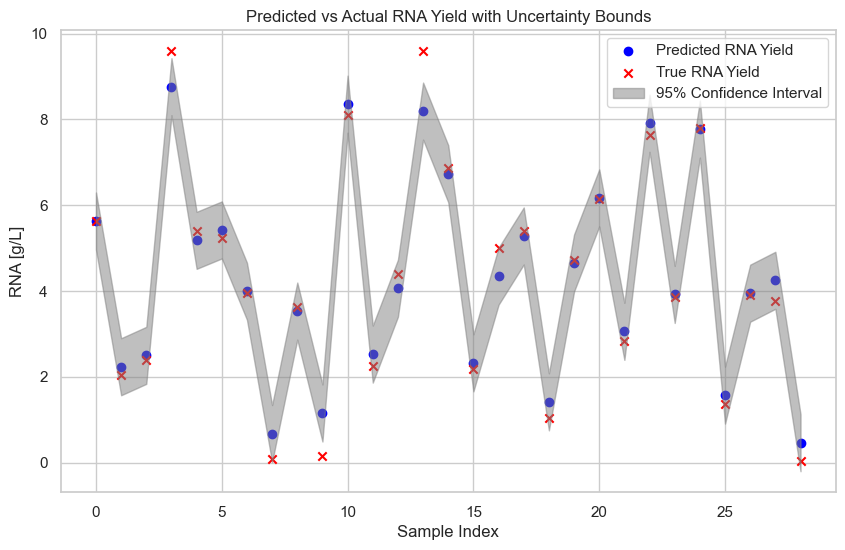

In [9]:
rbf_gp_model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=100,
    random_state=42,
)
rbf_gp_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
pre_scaled_pred = rbf_gp_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(pre_scaled_pred.reshape(-1, 1)).flatten()
print(
    "Root Mean squared error on training set:",
    np.sqrt(mean_squared_error(y_train, predictions)),
)
print(
    "R-squared score on training:", rbf_gp_model.score(X_train_scaled, y_train_scaled)
)

x_axis = np.arange(len(X_train))
plt.figure(figsize=(10, 6))
plt.scatter(
    x_axis,
    predictions,
    label="Predicted RNA Yield",
    color="blue",
    marker="o",
)
plt.scatter(x_axis, y_train, label="True RNA Yield", color="red", marker="x")
plt.fill_between(
    x_axis,
    predictions - 1.96 * np.sqrt(rbf_gp_model.kernel_.k2.noise_level),
    predictions + 1.96 * np.sqrt(rbf_gp_model.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Predicted vs Actual RNA Yield with Uncertainty Bounds")
plt.legend()

In [10]:
(
    X_train_scaled_reduced,
    X_test_scaled_reduced,
    y_train_scaled_reduced,
    y_test_scaled_reduced,
) = train_test_split(X_train_scaled, y_train_scaled, test_size=0.5, random_state=42)

# Train XGBoost model
xgboost_model.fit(X_train_scaled_reduced, y_train_scaled_reduced)
y_pred_xgb_scaled = xgboost_model.predict(X_test_scaled_reduced)
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_scaled_reduced.reshape(-1, 1)).flatten()

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Model:")
print(f"MAE: {mae_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"R^2: {r2_xgb:.3f}")

# Train RBF Gaussian Process model
rbf_gp_model.fit(X_train_scaled_reduced, y_train_scaled_reduced)
y_pred_gp_scaled = rbf_gp_model.predict(X_test_scaled_reduced)
y_pred_gp = scaler_y.inverse_transform(y_pred_gp_scaled.reshape(-1, 1)).flatten()

mae_gp = mean_absolute_error(y_test, y_pred_gp)
rmse_gp = np.sqrt(mean_squared_error(y_test, y_pred_gp))
r2_gp = r2_score(y_test, y_pred_gp)

print("\nRBF Gaussian Process Model:")
print(f"MAE: {mae_gp:.3f}")
print(f"RMSE: {rmse_gp:.3f}")
print(f"R^2: {r2_gp:.3f}")

XGBoost Model:
MAE: 1.459
RMSE: 1.819
R^2: 0.363

RBF Gaussian Process Model:
MAE: 1.704
RMSE: 2.127
R^2: 0.129


# Feature Engineering


## Dimensionality Reduction

We start from Partial Least Squares (PLS) regression, to identify latent variables
that explain the variance in the data.

<div style="text-align: center;">
  <img src="../../assets/pls.png" alt="PLS diagram">
</div>

Where $\mathbf{X}$ is the input data matrix, $\mathbf{Y}$ is the output data matrix,
$\mathbf{T}$ and $\mathbf{U}$ are the latent variables, $\mathbf{P}$ and $\mathbf{Q}$
are the loadings, and $\mathbf{E}$ and $\mathbf{F}$ are the residuals. We can express
the PLS regression model as follows:

$$
\begin{aligned}
& \mathbf{X}=\mathbf{T} \mathbf{P}^T+\mathbf{E} \\
& \mathbf{Y}=\mathbf{U} \mathbf{Q}^T+\mathbf{F}
\end{aligned}
$$


Best number of components: 1
R-squared: 0.41691135964816184
Root Mean Squared Error: 2.019357409209266


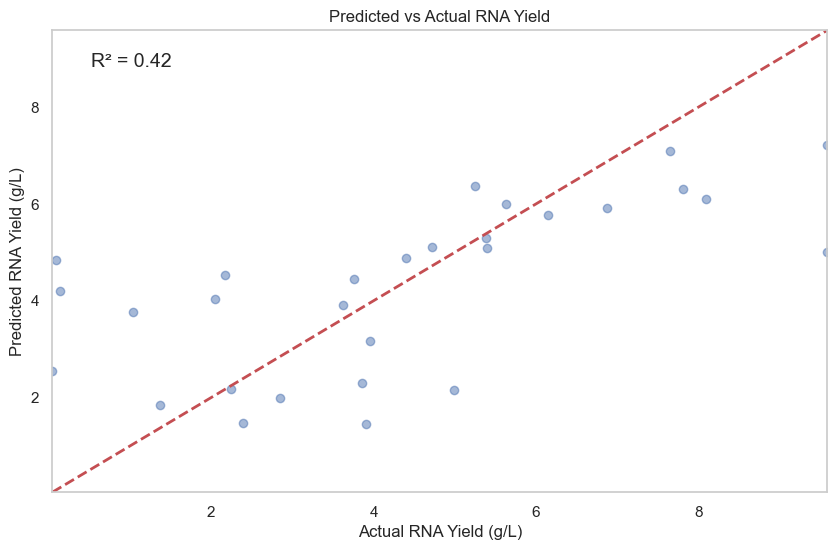

In [11]:
# Create a PLS model
pls = PLSRegression()

# Use GridSearchCV to find the best number of components using KFold cross-validation
param_grid = {"n_components": list(range(1, 10))}
kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

# Best number of components
best_n_components = grid_search.best_params_["n_components"]
print(f"Best number of components: {best_n_components}")

# Fit the PLS model with the best number of components
pls_best = PLSRegression(n_components=best_n_components)
pls_best.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
Y_pred_scaled = pls_best.predict(X_train_scaled)

# Inverse transform the predicted values
predictions = scaler_y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate mean squared error and root mean squared error for the predictions
rmse = np.sqrt(mean_squared_error(y_train, predictions))
# Calculate R-squared for the predictions
r2 = r2_score(y_train, predictions)

# Print results
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")


# Plot the predicted vs actual RNA yield
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predictions, alpha=0.5)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment="top",
)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.title("Predicted vs Actual RNA Yield")
plt.xlabel("Actual RNA Yield (g/L)")
plt.ylabel("Predicted RNA Yield (g/L)")
plt.xlim(y_train.min(), y_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.grid()

### Variables Importance in Projection (VIP)

The VIP scores are calculated as follows:

$$
\text{VIP}j = \sqrt{p \cdot \sum{a=1}^A \left( \frac{SSY*a \cdot
w*{ja}^2}{\sum\_{a=1}^A SSY_a} \right) }
$$

where:

- $p$ is the number of variables in $\mathbf{X}$
- $A$ is the number of components
- $SSY_a$ is the sum of squares of the response variable for component $a$
- $w_{ja}$ is the weight of variable $j$ for component $a$


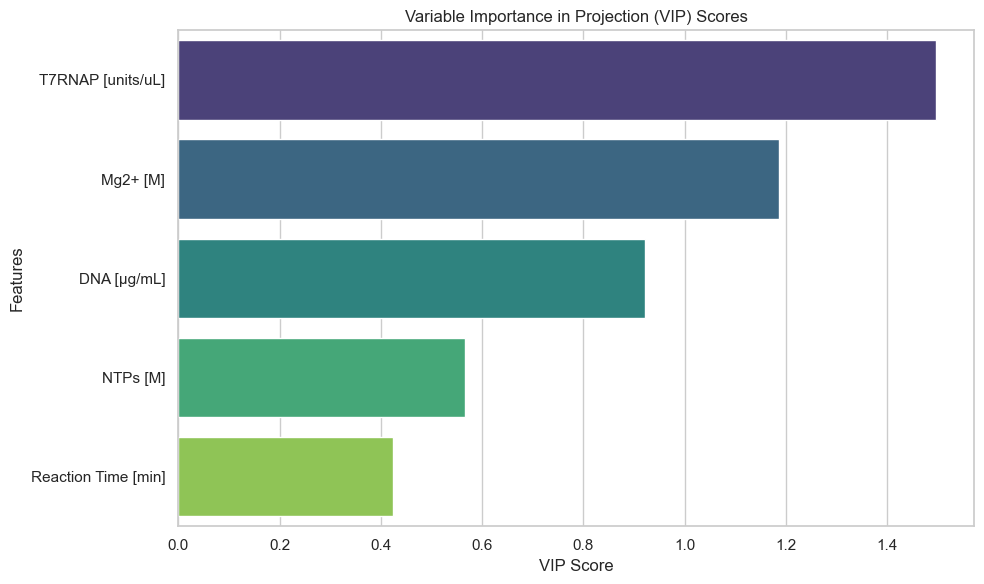

In [12]:
vip_scores = calculate_vip(pls_best, X_columns)
vip_scores = vip_scores.sort_values(by="VIP Score", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="VIP Score", y="Feature", data=vip_scores, palette="viridis")
plt.title("Variable Importance in Projection (VIP) Scores")
plt.xlabel("VIP Score")
plt.ylabel("Features")
plt.tight_layout()

#### Adding Noise Column

Usually VIP scores above 1 indicate that the variable is important for the model,
while scores below 0.8 indicate that the variable is not important. However, by
adding a dummy column with noisy data, we can identify the variables that correlate
with the noise, which can help us identify the variables that are not important for
the model.


3 variables have higher VIP than noise.


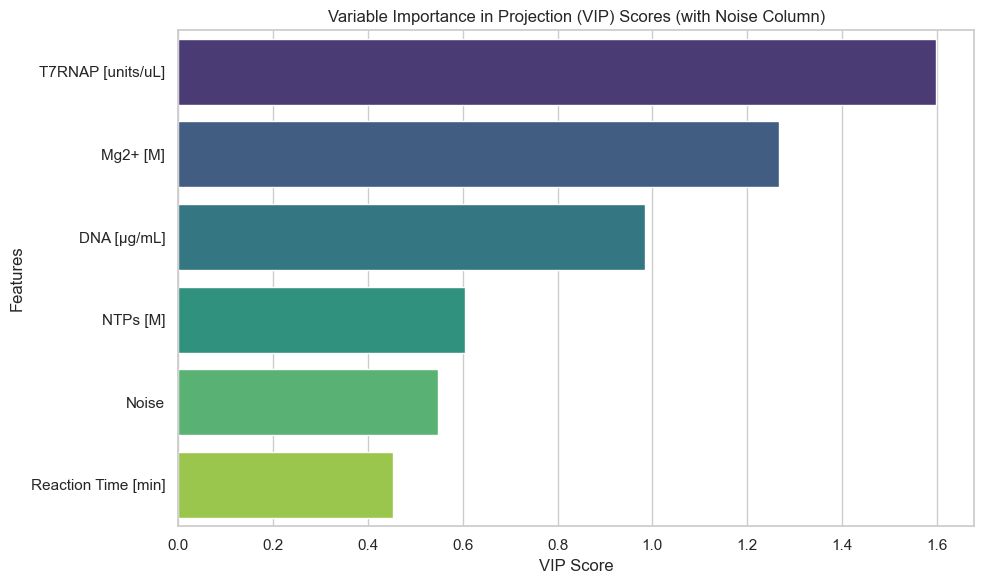

In [13]:
# Add a noise column to the scaled input
X_train_scaled_with_noise = np.hstack(
    [
        X_train_scaled,
        np.random.normal(loc=0.0, scale=1.0, size=(X_train_scaled.shape[0], 1)),
    ]
)
columns_with_noise = X_columns + ["Noise"]

# Fit PLS with noise column
pls_model_with_noise = PLSRegression(n_components=best_n_components)
pls_model_with_noise.fit(X_train_scaled_with_noise, y_train_scaled)
vip_scores_with_noise = calculate_vip(pls_model_with_noise, columns_with_noise)
vip_scores_with_noise = vip_scores_with_noise.sort_values(
    by="VIP Score", ascending=False
)

plt.figure(figsize=(10, 6))
sns.barplot(x="VIP Score", y="Feature", data=vip_scores_with_noise, palette="viridis")
plt.title("Variable Importance in Projection (VIP) Scores (with Noise Column)")
plt.xlabel("VIP Score")
plt.ylabel("Features")
plt.tight_layout()

# Print how many variables are more important than noise
noise_vip = vip_scores_with_noise[vip_scores_with_noise["Feature"] == "Noise"][
    "VIP Score"
].values[0]
n_above_noise = (
    vip_scores_with_noise["VIP Score"] > noise_vip
).sum() - 1  # exclude noise itself
print(f"{n_above_noise} variables have higher VIP than noise.")

## Analysis of Variance (ANOVA)

ANOVA is a statistical method used to analyze the differences among group means in a
sample. It helps to determine if there are any statistically significant differences
between the means of three or more independent groups.`


In [14]:
# Use descriptive variable names
anova_data = pd.DataFrame(
    data={
        "RNA_Yield": response.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
        "TIME_min": experimental_conditions[X_columns[4]].values.ravel(),
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = "RNA_Yield ~ NTP_M + T7RNAP_u_uL + DNA_ug_mL + Mg2_M + TIME_min + NTP_M * Mg2_M + T7RNAP_u_uL * NTP_M + T7RNAP_u_uL * DNA_ug_mL + T7RNAP_u_uL * Mg2_M + T7RNAP_u_uL * TIME_min + DNA_ug_mL * Mg2_M + DNA_ug_mL * TIME_min + Mg2_M * TIME_min + NTP_M * T7RNAP_u_uL * DNA_ug_mL + NTP_M * T7RNAP_u_uL * Mg2_M + NTP_M * T7RNAP_u_uL * TIME_min + NTP_M * DNA_ug_mL * Mg2_M + NTP_M * DNA_ug_mL * TIME_min + NTP_M * Mg2_M * TIME_min + T7RNAP_u_uL * DNA_ug_mL * Mg2_M + T7RNAP_u_uL * DNA_ug_mL * TIME_min + T7RNAP_u_uL * Mg2_M * TIME_min + DNA_ug_mL * Mg2_M * TIME_min"

lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)
print("\nANOVA Table:")
print(anova_results)

# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05

# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:              RNA_Yield   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     1.436
Date:                Sun, 13 Jul 2025   Prob (F-statistic):              0.437
Time:                        16:51:08   Log-Likelihood:                -32.199
No. Observations:                  29   AIC:                             116.4
Df Residuals:                       3   BIC:                             151.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Simplify the Linear Model


In [15]:
# Use descriptive variable names
anova_data = pd.DataFrame(
    data={
        "RNA_Yield": response.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
        "TIME_min": experimental_conditions[X_columns[4]].values.ravel(),
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = "RNA_Yield ~ NTP_M + T7RNAP_u_uL + DNA_ug_mL + Mg2_M + TIME_min + NTP_M * Mg2_M + T7RNAP_u_uL * NTP_M + T7RNAP_u_uL * DNA_ug_mL + T7RNAP_u_uL * Mg2_M + T7RNAP_u_uL * TIME_min + DNA_ug_mL * Mg2_M + DNA_ug_mL * TIME_min + Mg2_M * TIME_min"

lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)
print("\nANOVA Table:")
print(anova_results)

# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05

# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:              RNA_Yield   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     3.719
Date:                Sun, 13 Jul 2025   Prob (F-statistic):            0.00873
Time:                        16:51:08   Log-Likelihood:                -48.462
No. Observations:                  29   AIC:                             124.9
Df Residuals:                      15   BIC:                             144.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.89

A **lower value of BIC (Bayesian Information Criterion) or AIC (Akaike Information
Criterion)** means that the model is considered **better** in terms of balancing
goodness-of-fit and model complexity.

- **Lower AIC/BIC** = **better model** (among the models compared)
- Both penalize models for having more parameters, so a lower value suggests a model
  that fits the data well **without being overly complex**.

**In summary:**

- **Lower AIC/BIC = preferred model** (if comparing models on the same data).


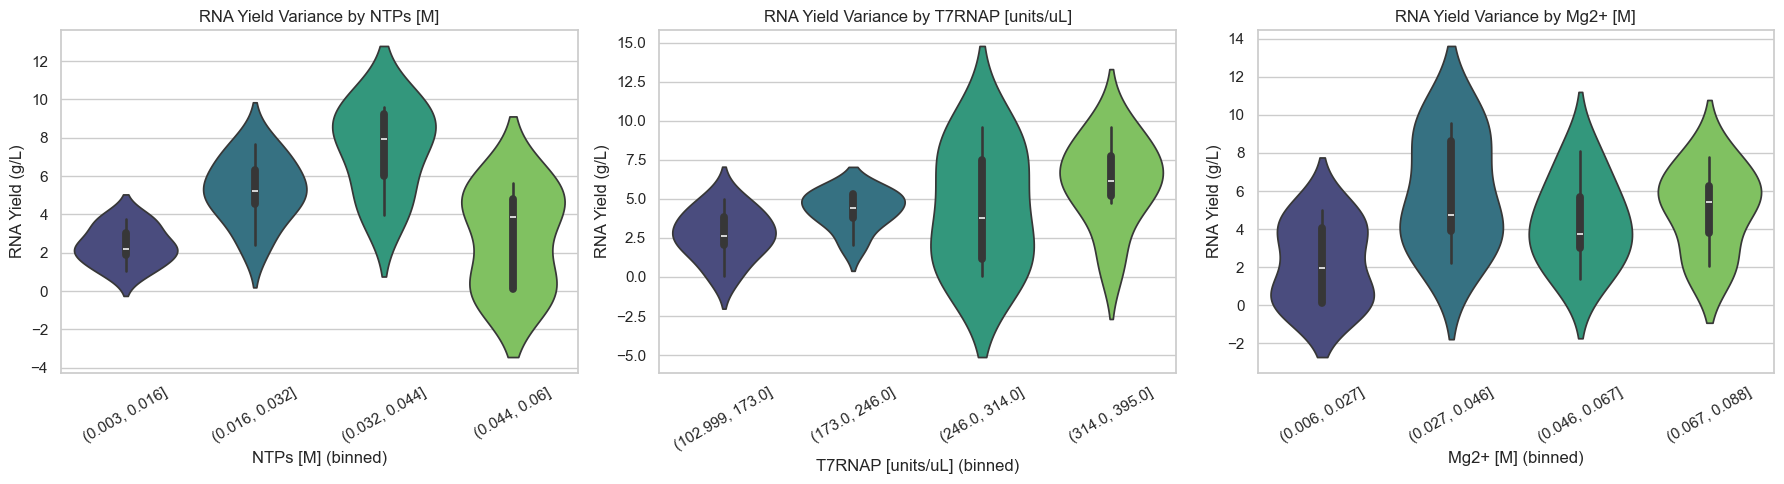

In [16]:
variables = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.Mg2_M.value,
]

yield_col = schema.IVTReactionSchema.RNA_g_L.value
df = experimental_data.copy()

# Bin each variable into categories for violin plot
n_bins = 4  # Adjust as needed
for var in variables:
    df[f"{var}_binned"] = pd.qcut(df[var], q=n_bins, duplicates="drop")

# Plot violin plots of RNA yield grouped by binned variable values
plt.figure(figsize=(18, 5))
for i, var in enumerate(variables):
    plt.subplot(1, len(variables), i + 1)
    sns.violinplot(
        x=f"{var}_binned", y=yield_col, data=df, inner="box", palette="viridis"
    )
    plt.xlabel(f"{var} (binned)")
    plt.ylabel("RNA Yield (g/L)")
    plt.title(f"RNA Yield Variance by {var}")
    plt.xticks(rotation=30)
plt.tight_layout()

Text(0.5, 0.92, '3D Scatter Plot of RNA Yield with OLS Regression Surface')

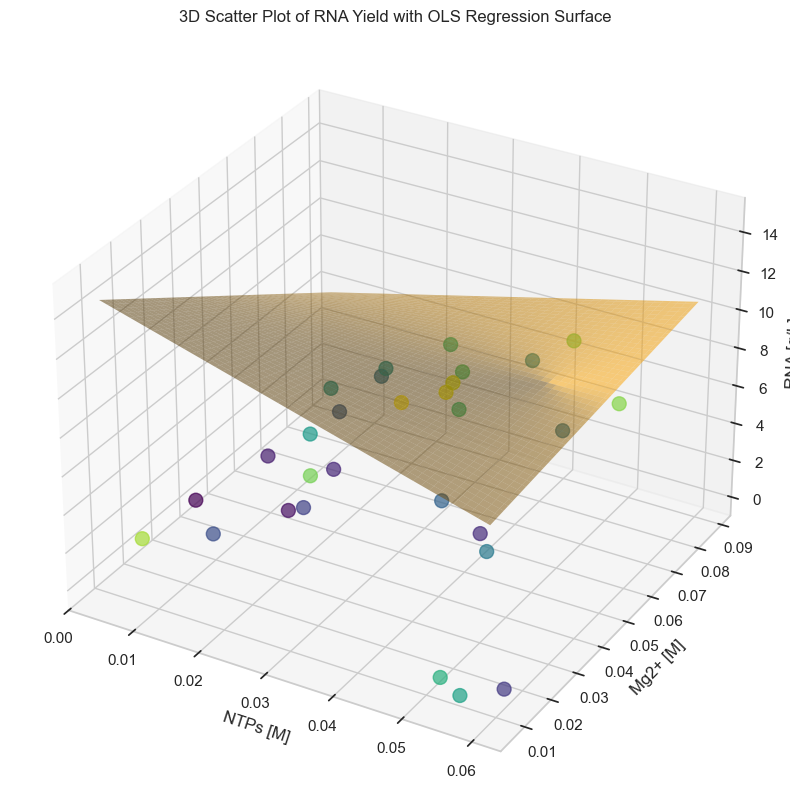

In [17]:
# Plot 3D scatter plot of RNA yield against NTP and Mg2+ concentrations with the OLS regression surface
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df[schema.IVTReactionSchema.NTP_M.value],
    df[schema.IVTReactionSchema.Mg2_M.value],
    df[yield_col],
    c=df[schema.IVTReactionSchema.T7RNAP_u_uL.value],
    cmap="viridis",
    marker="o",
    s=100,  # Increase particle size
    alpha=0.7,
)
# Use the second OLS model for the surface
x = np.linspace(
    df[schema.IVTReactionSchema.NTP_M.value].min(),
    df[schema.IVTReactionSchema.NTP_M.value].max(),
    100,
)
y = np.linspace(
    df[schema.IVTReactionSchema.Mg2_M.value].min(),
    df[schema.IVTReactionSchema.Mg2_M.value].max(),
    100,
)
X, Y = np.meshgrid(x, y)
Z = (
    lm.params["Intercept"]
    + lm.params["NTP_M"] * X
    + lm.params["Mg2_M"] * Y
    + lm.params["NTP_M:Mg2_M"] * X * Y
)
ax.plot_surface(
    X, Y, Z, alpha=0.5, color="orange", edgecolor="none", label="OLS Surface"
)
# increase particle size
ax.set_xlabel(schema.IVTReactionSchema.NTP_M.value)
ax.set_ylabel(schema.IVTReactionSchema.Mg2_M.value)
ax.set_zlabel(schema.IVTReactionSchema.RNA_g_L.value)
ax.set_title("3D Scatter Plot of RNA Yield with OLS Regression Surface")

## Feature Selection

We can reduce the model complexity by removing the interaction terms that are not
statistically significant.


In [18]:
# Use descriptive variable names
anova_data = pd.DataFrame(
    data={
        "RNA_Yield": response.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = (
    "RNA_Yield ~ NTP_M + T7RNAP_u_uL + Mg2_M + NTP_M * Mg2_M + T7RNAP_u_uL * DNA_ug_mL"
)

lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)
print("\nANOVA Table:")
print(anova_results)

# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05

# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:              RNA_Yield   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     8.544
Date:                Sun, 13 Jul 2025   Prob (F-statistic):           7.34e-05
Time:                        16:51:10   Log-Likelihood:                -51.907
No. Observations:                  29   AIC:                             117.8
Df Residuals:                      22   BIC:                             127.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.49

## Feature Extraction

Although we are assuming that there are no higher order interaction effects (3,4,..)
Linear Regression models are only linear in the weights and not in the input
variables!

This means that we can still model non-linear relationships by transforming the input
variables into polynomial features.

We can approximate any elementary function using a polynomial expansion. This allows
us to model complex relationships between the input variables and the output
variable.


Polynomial equation for NTPs [M]: -8240.881 * x^2 + 549.265 * x^1 + -2.635 * x^0
Polynomial equation for T7RNAP [units/uL]: 0.000 * x^2 + -0.003 * x^1 + 2.444 * x^0
Polynomial equation for Mg2+ [M]: -2137.944 * x^2 + 248.926 * x^1 + -1.388 * x^0


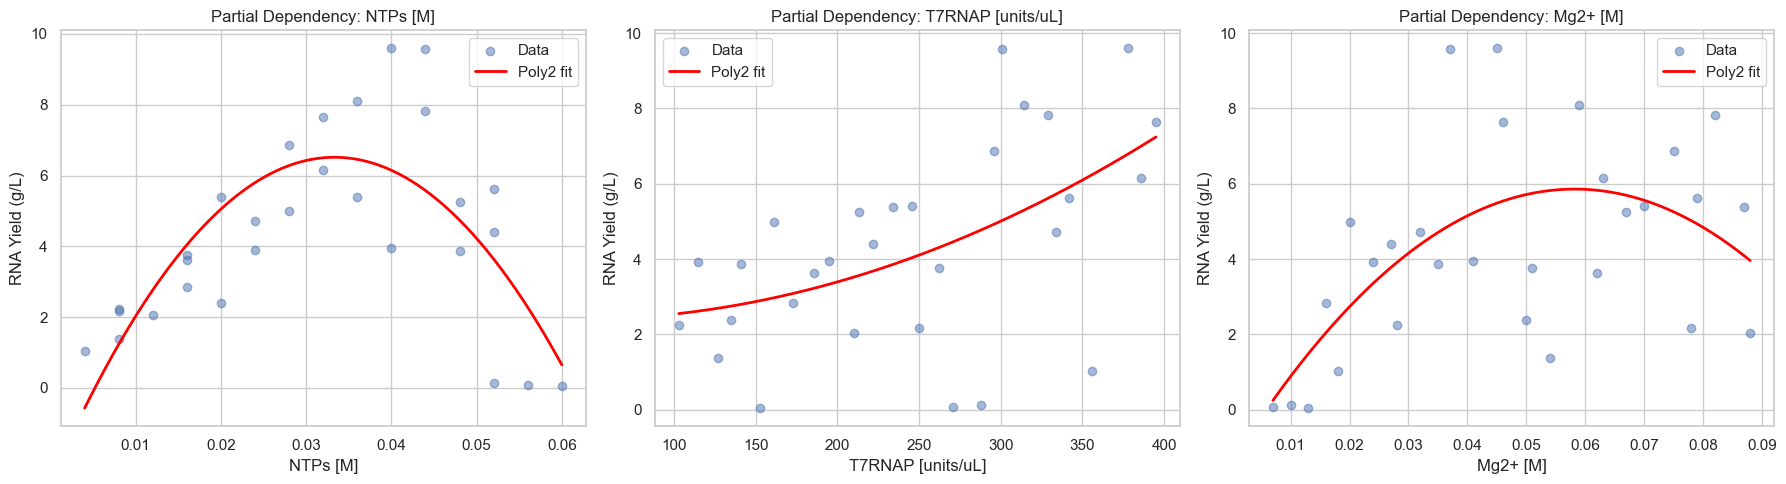

In [19]:
# Only include variables that are significant in the ANOVA model
variables = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.Mg2_M.value,
]
yield_col = schema.IVTReactionSchema.RNA_g_L.value
df = experimental_data.copy()

poly_degree = 2  # You can change this as needed
poly_equations = {}
plt.figure(figsize=(18, 5))
for i, var in enumerate(variables):
    x = df[var].values
    y = df[yield_col].values
    # Fit polynomial
    coeffs = np.polyfit(x, y, deg=poly_degree)
    poly_func = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = poly_func(x_fit)

    # Show polynomial coefficients and equation
    coeffs_str = ", ".join([f"{c:.3f}" for c in coeffs])
    equation = " + ".join(
        [f"{c:.3f} * x^{len(coeffs) - i - 1}" for i, c in enumerate(coeffs)]
    )
    print(f"Polynomial equation for {var}: {equation}")
    poly_equations[var] = {
        "coefficients": coeffs,
        "equation": equation,
    }

    plt.subplot(1, len(variables), i + 1)
    # Scatter actual data
    plt.scatter(x, y, alpha=0.5, label="Data")
    # Overlay fitted line
    plt.plot(x_fit, y_fit, color="red", lw=2, label=f"Poly{poly_degree} fit")
    plt.xlabel(var)
    plt.ylabel("RNA Yield (g/L)")
    plt.title(f"Partial Dependency: {var}")
    plt.legend()
plt.tight_layout()

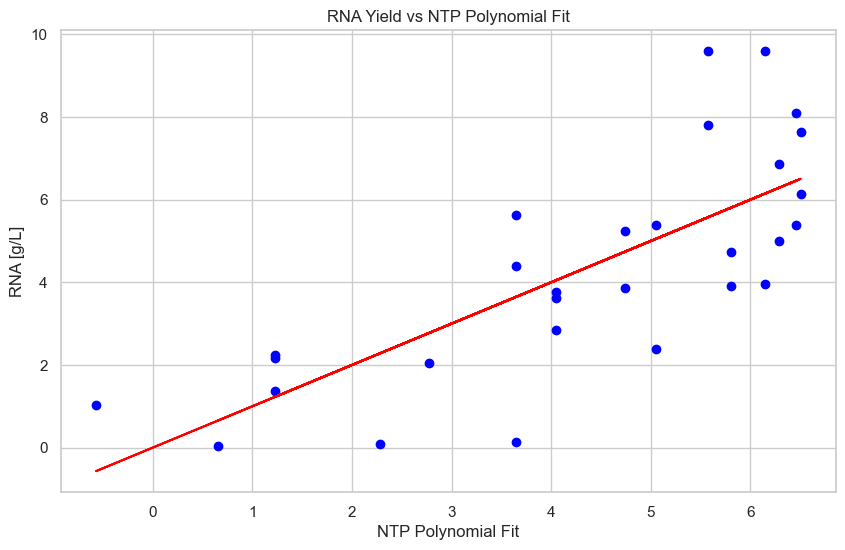

In [20]:
# plot the RNA yield against the NTP polynomial fits generated above
ntp = experimental_conditions[schema.IVTReactionSchema.NTP_M.value].values.ravel()
ntp_equation = -8240.881 * ntp**2 + 549.265 * ntp**1 + -2.635 * ntp**0

plt.figure(figsize=(10, 6))
plt.scatter(
    ntp_equation,
    response[schema.IVTReactionSchema.RNA_g_L.value].values.ravel(),
    color="blue",
    marker="o",
)
# add labels to the plot
plt.xlabel("NTP Polynomial Fit")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("RNA Yield vs NTP Polynomial Fit")

# add trend line
z = np.polyfit(
    ntp_equation, response[schema.IVTReactionSchema.RNA_g_L.value].values.ravel(), 1
)
p = np.poly1d(z)
plt.plot(
    ntp_equation,
    p(ntp_equation),
    color="red",
    label="Trend Line",
)

In [21]:
ntp = experimental_conditions[schema.IVTReactionSchema.NTP_M.value].values.ravel()
ntp_equation = -8240.881 * ntp**2 + 549.265 * ntp**1 + -2.635 * ntp**0
t7_rnap = experimental_conditions[
    schema.IVTReactionSchema.T7RNAP_u_uL.value
].values.ravel()
t7_rnap_equation = 0.000 * t7_rnap**2 - 0.003 * t7_rnap + 2.444 * t7_rnap**0
mg2 = experimental_conditions[schema.IVTReactionSchema.Mg2_M.value].values.ravel()
mg2_equation = -2137.944 * mg2**2 + 248.926 * mg2 + -1.388 * mg2**0

# Use descriptive variable names

anova_data = pd.DataFrame(
    data={
        "RNA_Yield": response.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
        "NTP_equation": ntp_equation,
        "T7RNAP_equation": t7_rnap_equation,
        "Mg2_equation": mg2_equation,
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = "RNA_Yield ~ NTP_M + T7RNAP_u_uL + Mg2_M + NTP_M * Mg2_M + T7RNAP_u_uL * DNA_ug_mL + NTP_equation + T7RNAP_equation + Mg2_equation"
lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)

print("\nANOVA Table:")
print(anova_results)


# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05


# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:              RNA_Yield   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     12.85
Date:                Sun, 13 Jul 2025   Prob (F-statistic):           2.33e-06
Time:                        16:51:11   Log-Likelihood:                -43.038
No. Observations:                  29   AIC:                             104.1
Df Residuals:                      20   BIC:                             116.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.00

# Model Development

Now we can develop a model using the selected features and the polynomial features.
Since we want a predictive model, we can use a Random Forest Regressor or a Gradient
Boosting Regressor or Gaussian Process Regression (GPR) models.


In [22]:
# Select statistically significant features and polynomial features
features = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    "NTPs [M]:Mg2+ [M]",  # interaction term
    "T7RNAP_equation",
    "NTP_equation",
    "Mg2_equation",
]

# Prepare the feature matrix
df = experimental_data.copy()
df["NTP_equation"] = ntp_equation
df["T7RNAP_equation"] = t7_rnap_equation
df["Mg2_equation"] = mg2_equation
df["NTPs [M]:Mg2+ [M]"] = (
    df[schema.IVTReactionSchema.NTP_M.value] * df[schema.IVTReactionSchema.Mg2_M.value]
)

X = df[
    [
        "NTPs [M]",
        "T7RNAP [units/uL]",
        "Mg2+ [M]",
        "NTPs [M]:Mg2+ [M]",
        "NTP_equation",
        "T7RNAP_equation",
        "Mg2_equation",
    ]
].values
y = df["RNA [g/L]"].values

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize using training set statistics
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Gaussian Process
rbf_gp = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
rbf_gp.fit(X_train_scaled, y_train_scaled)
y_pred_gp_train = scaler_y.inverse_transform(
    rbf_gp.predict(X_train_scaled).reshape(-1, 1)
).flatten()
y_pred_gp_test = scaler_y.inverse_transform(
    rbf_gp.predict(X_test_scaled).reshape(-1, 1)
).flatten()

# XGBoost
xgb = xgboost.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
)
xgb.fit(X_train_scaled, y_train_scaled)
y_pred_xgb_train = scaler_y.inverse_transform(
    xgb.predict(X_train_scaled).reshape(-1, 1)
).flatten()
y_pred_xgb_test = scaler_y.inverse_transform(
    xgb.predict(X_test_scaled).reshape(-1, 1)
).flatten()

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)
y_pred_rf_train = scaler_y.inverse_transform(
    rf.predict(X_train_scaled).reshape(-1, 1)
).flatten()
y_pred_rf_test = scaler_y.inverse_transform(
    rf.predict(X_test_scaled).reshape(-1, 1)
).flatten()


print("Gaussian Process (RBF):")
print(
    "  Train RMSE =",
    np.sqrt(mean_squared_error(y_train, y_pred_gp_train)),
    "R2 =",
    r2_score(y_train, y_pred_gp_train),
    "MAE =",
    mean_absolute_error(y_train, y_pred_gp_train),
)
print(
    "  Test  RMSE =",
    np.sqrt(mean_squared_error(y_test, y_pred_gp_test)),
    "R2 =",
    r2_score(y_test, y_pred_gp_test),
    "MAE =",
    mean_absolute_error(y_test, y_pred_gp_test),
)

print("XGBoost:")
print(
    "  Train RMSE =",
    np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)),
    "R2 =",
    r2_score(y_train, y_pred_xgb_train),
    "MAE =",
    mean_absolute_error(y_train, y_pred_xgb_train),
)
print(
    "  Test  RMSE =",
    np.sqrt(mean_squared_error(y_test, y_pred_xgb_test)),
    "R2 =",
    r2_score(y_test, y_pred_xgb_test),
    "MAE =",
    mean_absolute_error(y_test, y_pred_xgb_test),
)

print("Random Forest:")
print(
    "  Train RMSE =",
    np.sqrt(mean_squared_error(y_train, y_pred_rf_train)),
    "R2 =",
    r2_score(y_train, y_pred_rf_train),
    "MAE =",
    mean_absolute_error(y_train, y_pred_rf_train),
)
print(
    "  Test  RMSE =",
    np.sqrt(mean_squared_error(y_test, y_pred_rf_test)),
    "R2 =",
    r2_score(y_test, y_pred_rf_test),
    "MAE =",
    mean_absolute_error(y_test, y_pred_rf_test),
)

Gaussian Process (RBF):
  Train RMSE = 0.7143727677227504 R2 = 0.9321349210706631 MAE = 0.5608364993176336
  Test  RMSE = 0.9336525531027138 R2 = 0.822698516424211 MAE = 0.7417407137100741
XGBoost:
  Train RMSE = 0.018887008697527453 R2 = 0.9999525623749759 MAE = 0.015200890706155663
  Test  RMSE = 0.9353213698309505 R2 = 0.8220641302963737 MAE = 0.8429687609036761
Random Forest:
  Train RMSE = 0.598768904900062 R2 = 0.9523223265899927 MAE = 0.44676771195652204
  Test  RMSE = 1.3410002421720297 R2 = 0.6342372248280751 MAE = 1.0753793749999996


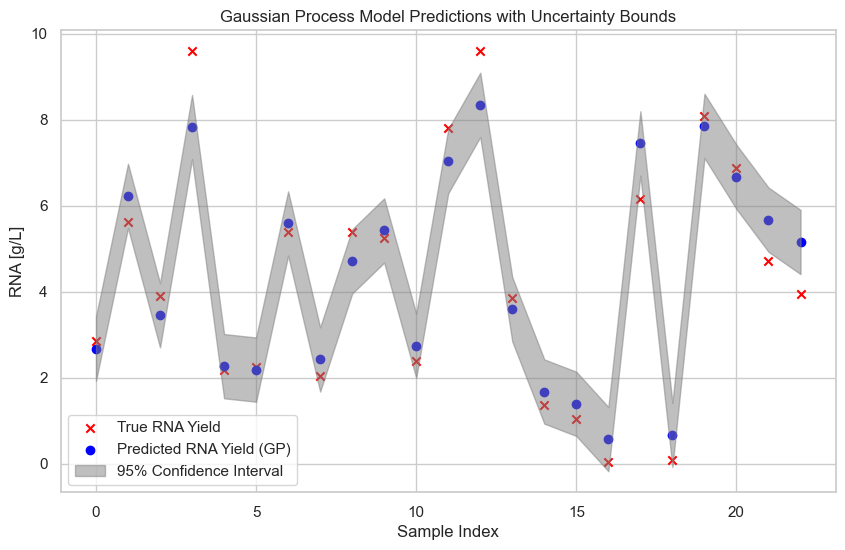

In [23]:
# Plot gaussian process model predictions
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_train)), y_train, label="True RNA Yield", color="red", marker="x"
)
plt.scatter(
    np.arange(len(y_pred_gp_train)),
    y_pred_gp_train,
    label="Predicted RNA Yield (GP)",
    color="blue",
    marker="o",
)
plt.fill_between(
    np.arange(len(y_pred_gp_train)),
    y_pred_gp_train - 1.96 * np.sqrt(rbf_gp.kernel_.k2.noise_level),
    y_pred_gp_train + 1.96 * np.sqrt(rbf_gp.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Gaussian Process Model Predictions with Uncertainty Bounds")
plt.legend()

Lets interpret the model using SHAP values to understand the contribution of each feature
to the model prediction. SHAP values cannot be used to replaced variable importance analysis such as looking at the length scale of the features, also SHAP values assume additive relationships between the features and the output variable, which may not be the case for all models. However, they can help us debug the model.

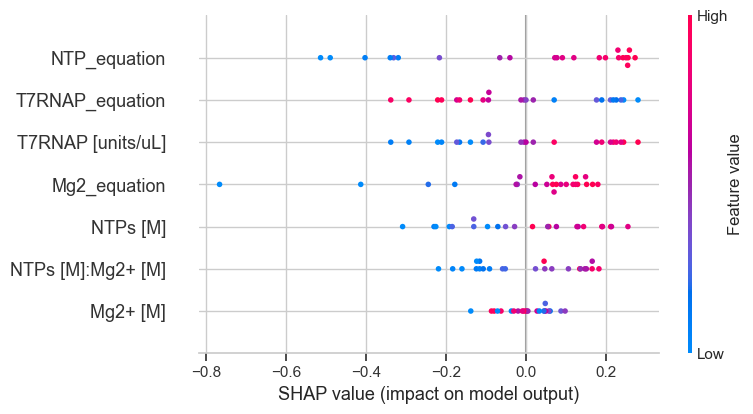

In [24]:
# Shap plots on the Gaussian Process model
explainer_gp = shap.Explainer(rbf_gp.predict, X_train_scaled)
shap_values_gp = explainer_gp(X_train_scaled)
shap.summary_plot(
    shap_values_gp,
    X_train_scaled,
    feature_names=[
        "NTPs [M]",
        "T7RNAP [units/uL]",
        "Mg2+ [M]",
        "NTPs [M]:Mg2+ [M]",
        "NTP_equation",
        "T7RNAP_equation",
        "Mg2_equation",
    ],
)

Gaussian Process (RBF) without equations:
  Train RMSE = 0.5503378599938439 R2 = 0.9597231628833537 MAE = 0.45989050599461284
  Test  RMSE = 1.162924990427637 R2 = 0.7249287519641086 MAE = 0.9320642943667234


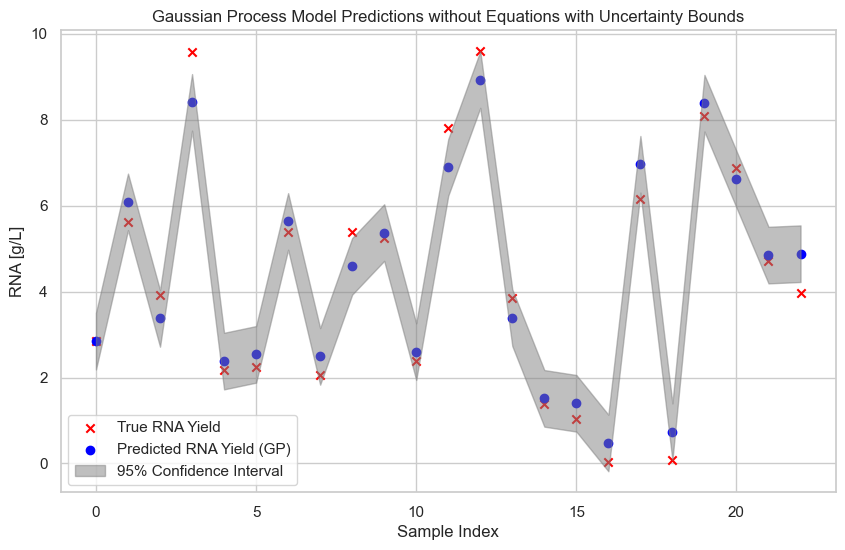

In [25]:
# Remove the equation features and retrain the Gaussian Process model

X_train_scaled_reduced = X_train_scaled[:, :-3]  # Remove last 3 columns (equations)
X_test_scaled_reduced = X_test_scaled[:, :-3]

rbf_gp_reduced = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=50,
    random_state=42,
)
rbf_gp_reduced.fit(X_train_scaled_reduced, y_train_scaled)
y_pred_gp_train_reduced = scaler_y.inverse_transform(
    rbf_gp_reduced.predict(X_train_scaled_reduced).reshape(-1, 1)
).flatten()

y_pred_gp_test_reduced = scaler_y.inverse_transform(
    rbf_gp_reduced.predict(X_test_scaled_reduced).reshape(-1, 1)
).flatten()

print("Gaussian Process (RBF) without equations:")
print(
    "  Train RMSE =",
    np.sqrt(mean_squared_error(y_train, y_pred_gp_train_reduced)),
    "R2 =",
    r2_score(y_train, y_pred_gp_train_reduced),
    "MAE =",
    mean_absolute_error(y_train, y_pred_gp_train_reduced),
)
print(
    "  Test  RMSE =",
    np.sqrt(mean_squared_error(y_test, y_pred_gp_test_reduced)),
    "R2 =",
    r2_score(y_test, y_pred_gp_test_reduced),
    "MAE =",
    mean_absolute_error(y_test, y_pred_gp_test_reduced),
)
# Plot gaussian process model predictions without equations
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_train)), y_train, label="True RNA Yield", color="red", marker="x"
)
plt.scatter(
    np.arange(len(y_pred_gp_train_reduced)),
    y_pred_gp_train_reduced,
    label="Predicted RNA Yield (GP)",
    color="blue",
    marker="o",
)
plt.fill_between(
    np.arange(len(y_pred_gp_train_reduced)),
    y_pred_gp_train_reduced - 1.96 * np.sqrt(rbf_gp_reduced.kernel_.k2.noise_level),
    y_pred_gp_train_reduced + 1.96 * np.sqrt(rbf_gp_reduced.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title(
    "Gaussian Process Model Predictions without Equations with Uncertainty Bounds"
)
plt.legend()

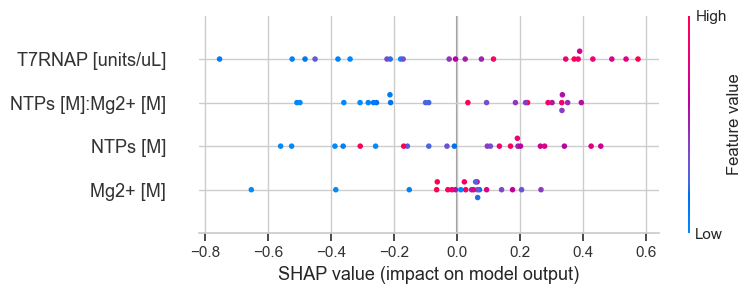

In [26]:
# Shap plots on the Gaussian Process model
explainer_gp = shap.Explainer(rbf_gp_reduced.predict, X_train_scaled_reduced)
shap_values_gp = explainer_gp(X_train_scaled_reduced)
shap.summary_plot(
    shap_values_gp,
    X_train_scaled_reduced,
    feature_names=[
        "NTPs [M]",
        "T7RNAP [units/uL]",
        "Mg2+ [M]",
        "NTPs [M]:Mg2+ [M]",
        "NTP_equation",
        "T7RNAP_equation",
        "Mg2_equation",
    ],
)